## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [55]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, encoder='pretrained MAE'):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    fig = plt.figure()

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    fig.suptitle('Reconstruction with frozen {} encoder'.format(encoder), fontsize=16, y=0.65)
    fig.tight_layout()
    #fig.subplots_adjust(top=0.95)
    fig.savefig(encoder+' reconstruction.png', dpi=300)
    plt.show()

### Load an image

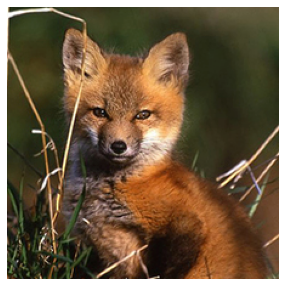

In [3]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [47]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/checkpoints/MAE/vit_base_patch16/checkpoint-100.pth'
model_mae_frozen_dino = prepare_model(chkpt_dir, 'vit_base_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


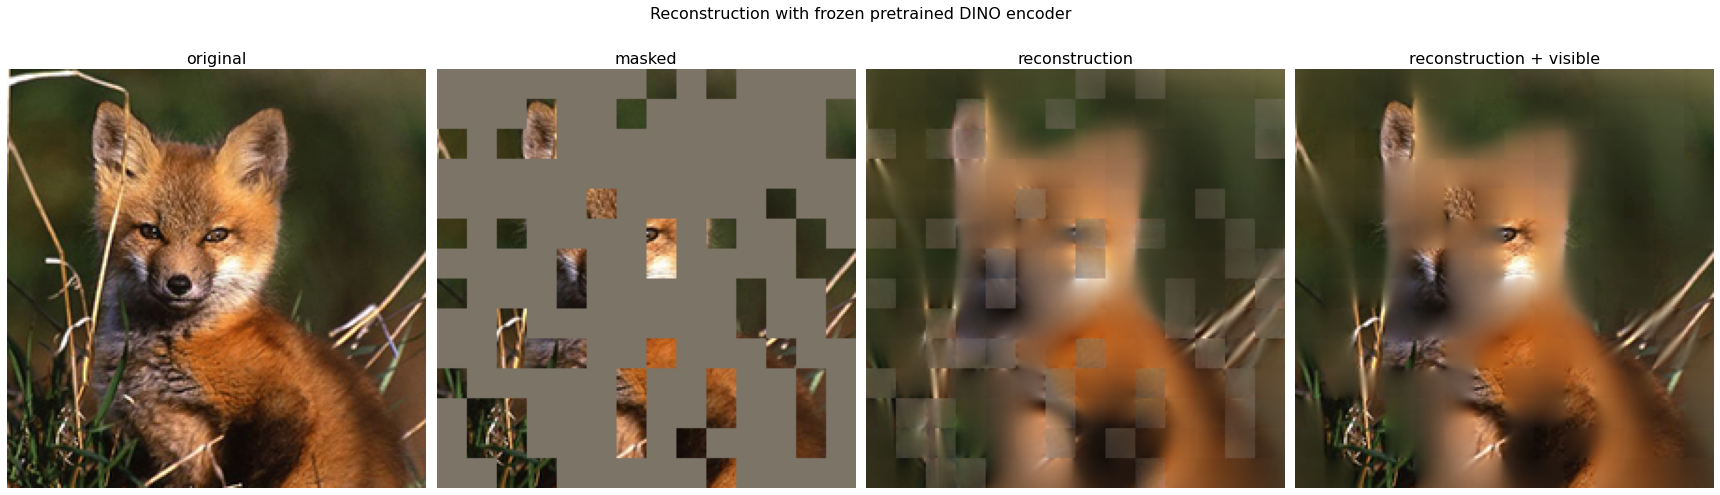

In [56]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae_frozen_dino, 'pretrained DINO')

### Load another pre-trained MAE model

In [58]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = '/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/frozen_mae/checkpoints/MAE/vit_base_patch16/checkpoint-100.pth'
model_mae_frozen_mae = prepare_model(chkpt_dir, 'vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with frozen MAE encoder:


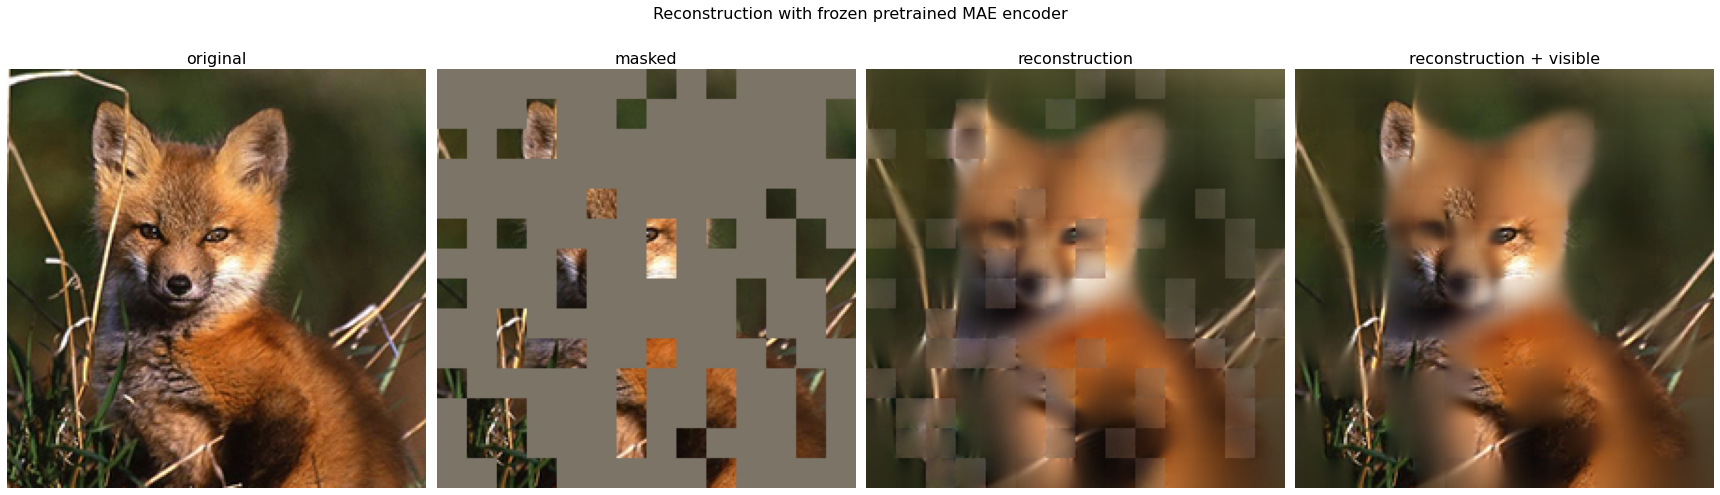

In [59]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with frozen MAE encoder:')
run_one_image(img, model_mae_frozen_mae, 'pretrained MAE')

In [60]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = '/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/random_init/checkpoints/MAE/vit_base_patch16/checkpoint-100.pth'
model_mae_frozen_random = prepare_model(chkpt_dir, 'vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with frozen MAE encoder:


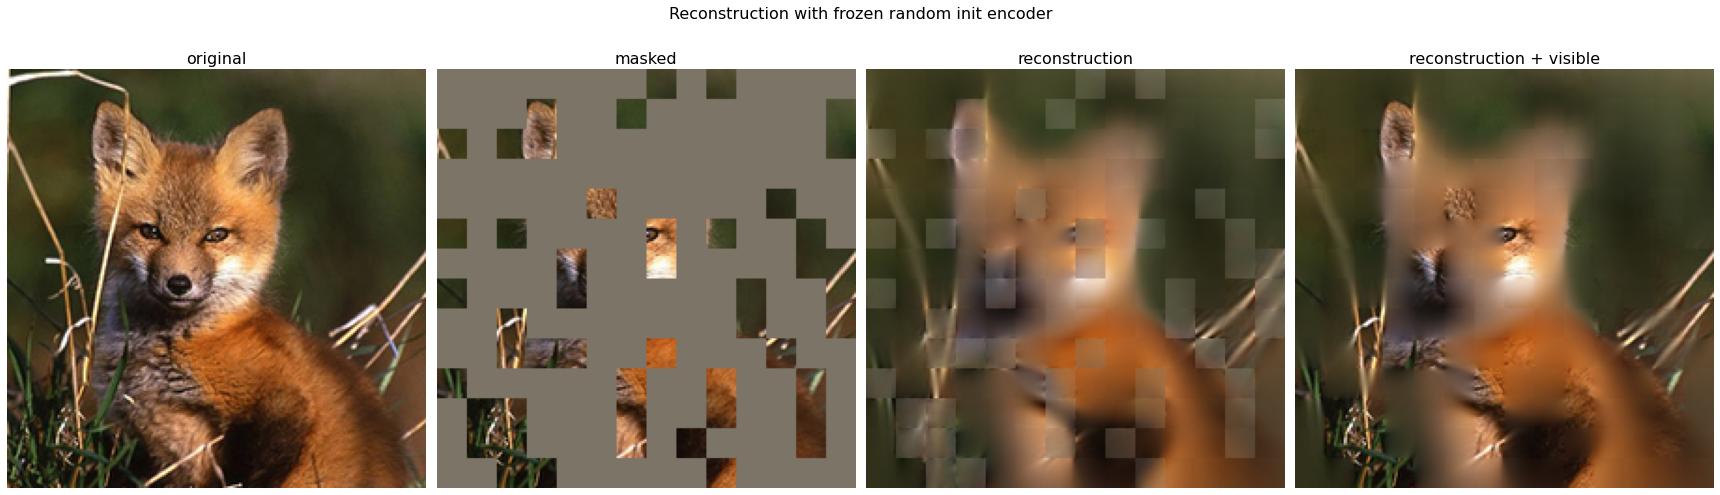

In [61]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with frozen MAE encoder:')
run_one_image(img, model_mae_frozen_random, 'random init')

In [64]:
from ast import literal_eval
import pandas as pd

In [70]:
results = {'MAE': [], 'Random': [], 'DINO': []}

for key in results:
    if key == 'DINO':
        key_to_use = ''
    elif key == 'MAE':
        key_to_use = 'frozen_MAE/'
    else:
        key_to_use = 'random_init/'

    folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/" + key_to_use.lower() + "logs/MAE/vit_base_patch16/SLURM/"

    print(folder_name)
    for root, dirs, files in os.walk(folder_name):
        #if root[len(folder_name):].count(os.sep) < 2:
            for file in files:
                if file == 'log.txt':
                    log_file = os.path.join(root, file) 

    log_list = []
    print(log_file)
    if os.path.isfile(log_file): 
        with open(log_file, "r") as log:
            for line in log:
                log_dict = literal_eval(line)
                log_list.append(log_dict)
               
    df = pd.DataFrame(log_list)
    df = df.set_index('epoch')
    results[key] = df

/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/frozen_mae/logs/MAE/vit_base_patch16/SLURM/
/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/frozen_mae/logs/MAE/vit_base_patch16/SLURM/2017409/MAE/vit_base_patch16/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/random_init/logs/MAE/vit_base_patch16/SLURM/
/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/random_init/logs/MAE/vit_base_patch16/SLURM/2017441/MAE/vit_base_patch16/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/logs/MAE/vit_base_patch16/SLURM/
/checkpoint/sshkhr/experiments/ViT-analysis/freeze_encoder/logs/MAE/vit_base_patch16/SLURM/2012156/MAE/vit_base_patch16/log.txt


In [71]:
import seaborn as sns

In [84]:
def dynamics_plot_single(fig_dir, df1, df2, df3, name1, name2, name3, col):

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

    sns.lineplot(x='epoch', y=col, data = df1, ax = ax)
    sns.lineplot(x='epoch', y=col, data = df2, ax = ax)
    sns.lineplot(x='epoch', y=col, data = df3, ax = ax)
    
    ax.set_xlabel("Decoder Training Epochs")
    ax.set_ylabel(col)
    
    ax.legend(title='Encoder Initialization', loc='upper right', labels=[name1, name2, name3])
    plt.tight_layout()

    plt.xlim(0, 200)
    plt.show()

    fig.savefig(fig_dir+name1+'-'+name2+'-'+name3+'.png')

    return fig

In [74]:
import itertools

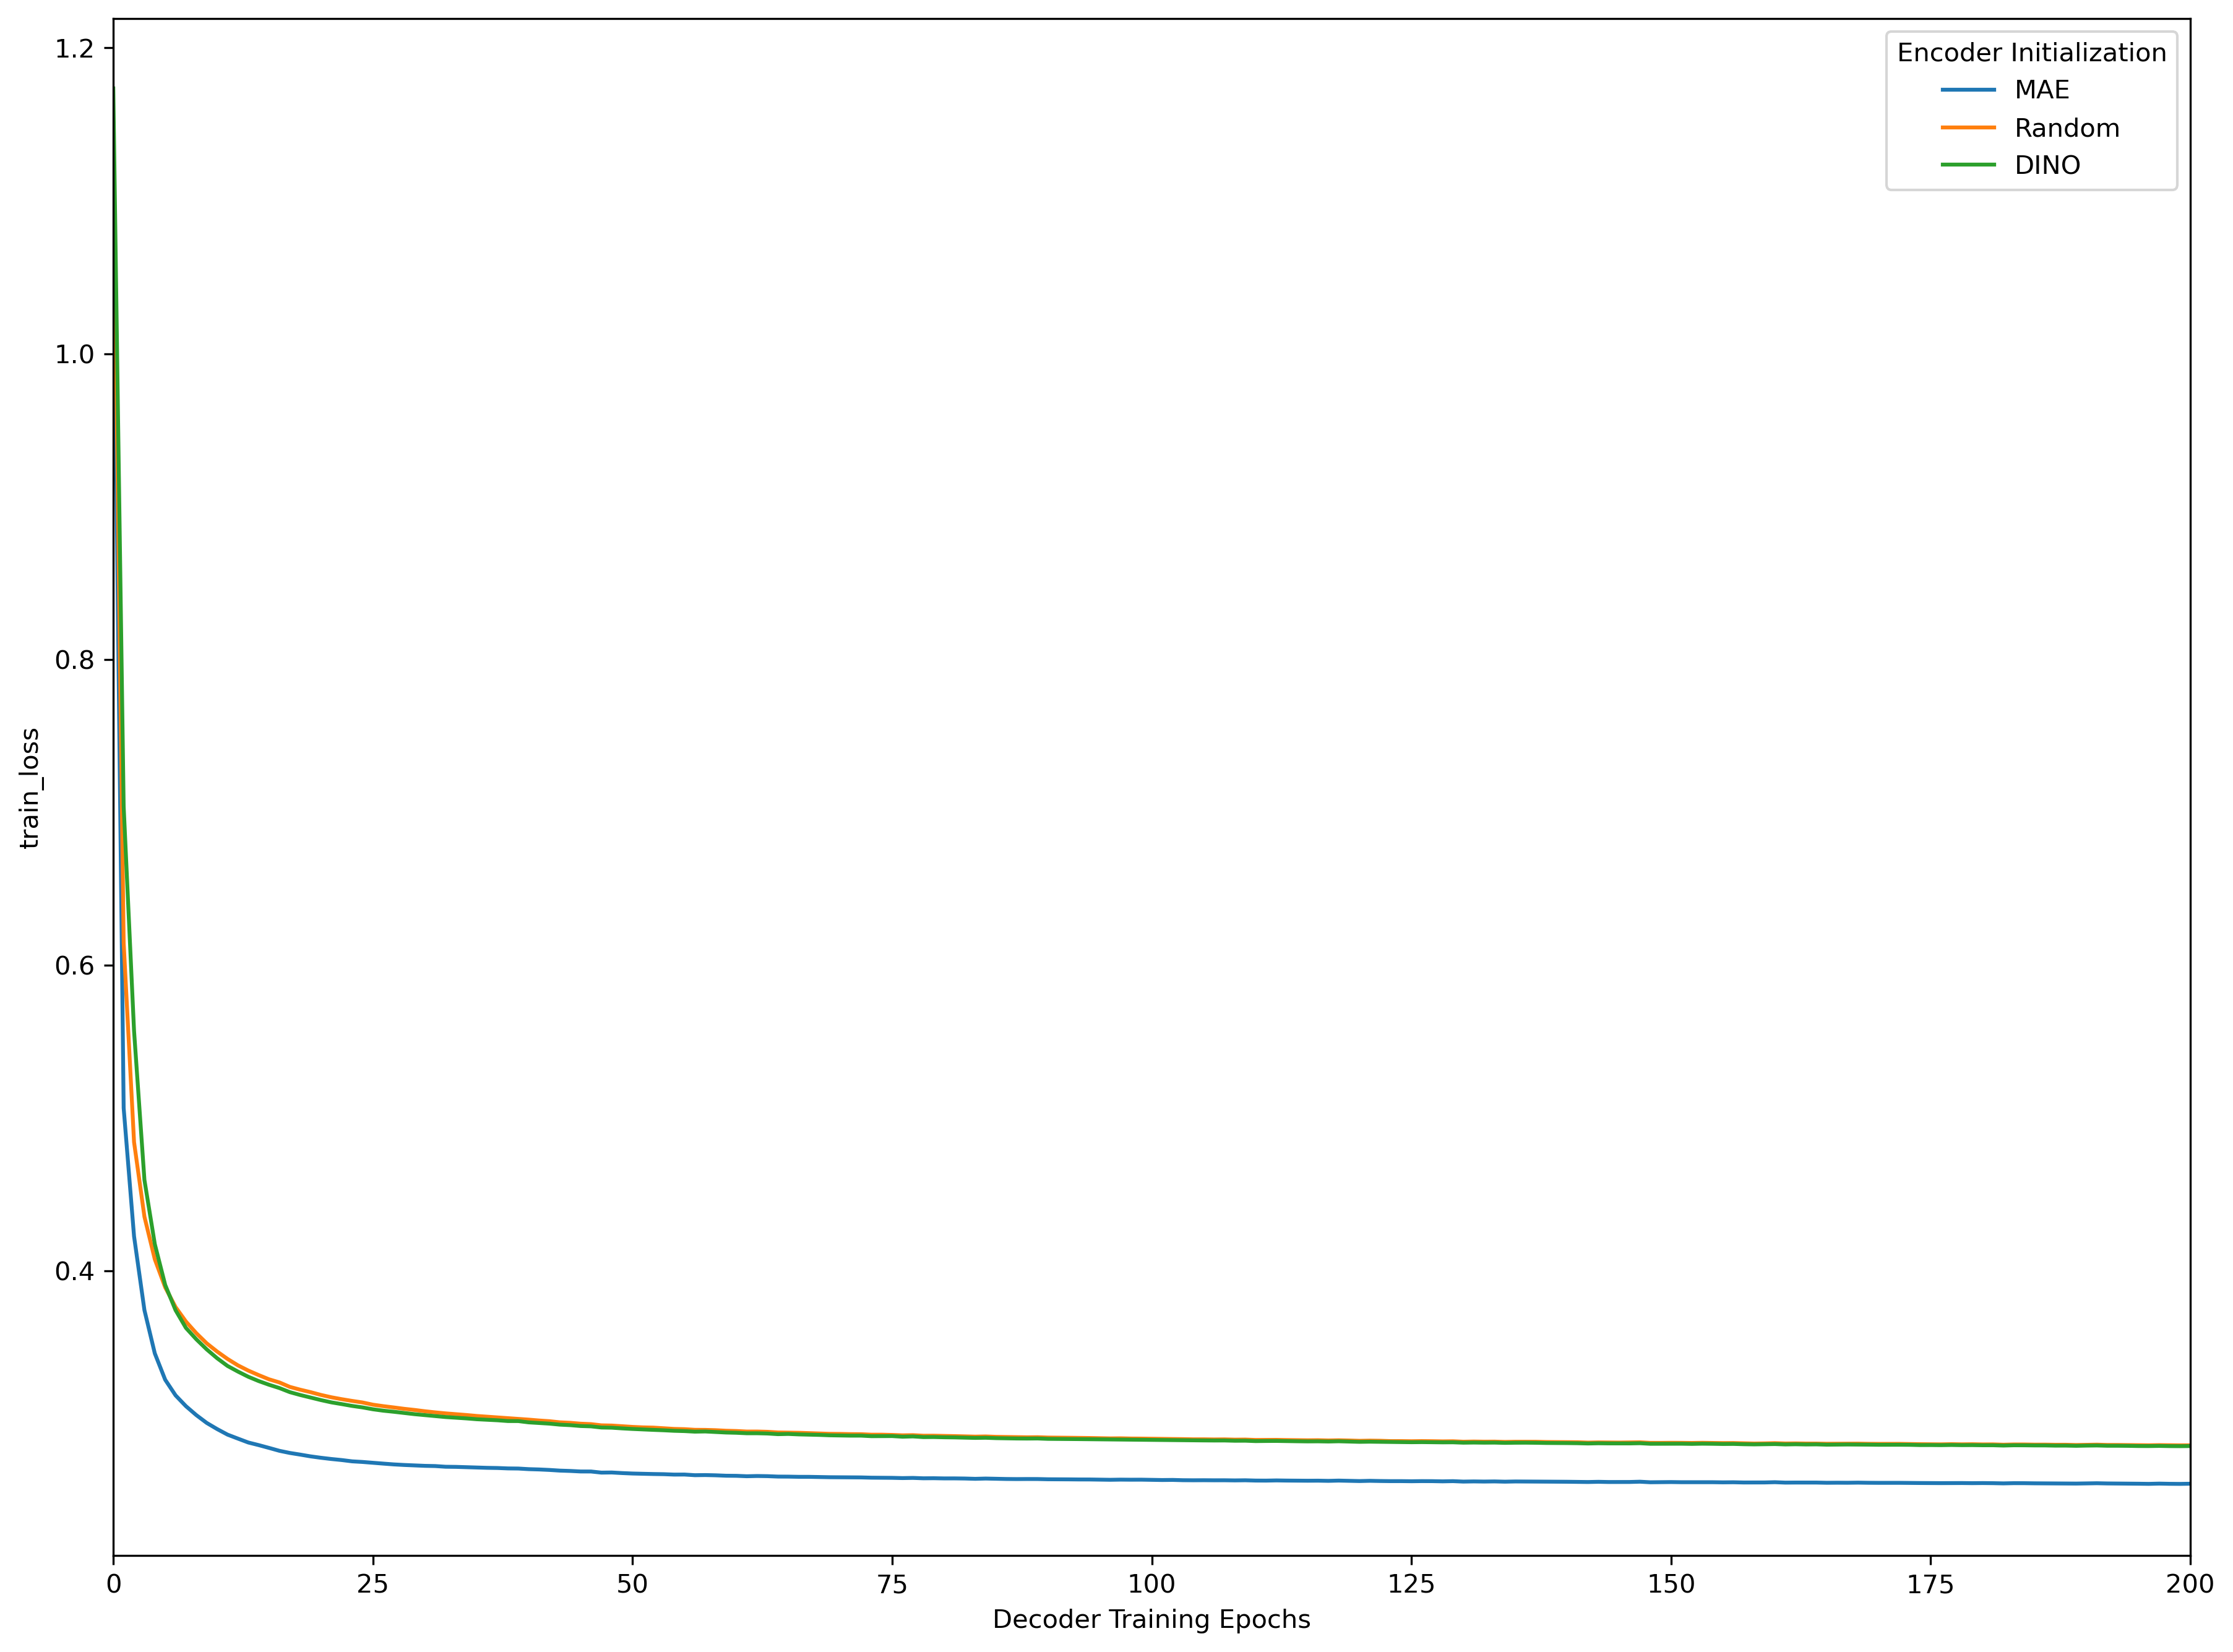

In [85]:
fig_dir = '../figures/'

prod = itertools.combinations(results.keys(), 3)

for name1, name2, name3 in prod: #results.keys():
    for col in ["train_loss"]:
        fig = dynamics_plot_single(fig_dir, results[name1], results[name2], results[name3], name1, name2, name3, col=col)